## Importing the packages

In [8]:
import torch
%matplotlib inline
import PIL
import keras 
import skimage
from PIL import Image
from torch import nn, optim
from keras.layers import Lambda, Input, Dense
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from zipfile import ZipFile
# from io import BytesIO
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from IPython.display import display
from skimage.io import imread_collection
from keras.models import load_model
import h5py

## Loading the Dataset

In [2]:
seq = imread_collection("train/*.jpg", conserve_memory=True)

/datasets/home/51/351/earya/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/datasets/home/51/351/earya/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


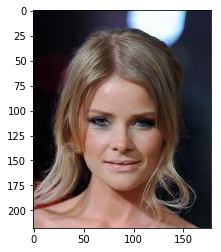

In [3]:
images = np.zeros((50, 56, 56, 1))
for i in range(50):
    image = skimage.transform.resize(seq[i], (56, 56, 3))
    images[i,:,:,0]= rgb2gray(image)
    
N = 10
N_vae = 128
seq = imread_collection("img_align_celeba/*.jpg", conserve_memory=True)
img = seq[0]   ## CHANGE HERE TO SEE DIFFERENT IMAGES OF THE DATASET
imgplot = plt.imshow(img)

images_i = np.zeros((N, seq[0].shape[0], seq[0].shape[1], 1))
x_test = np.zeros((N, 56,56,1))
x_test_gan = np.zeros((N, 32,32,3))
x_test_vae = np.zeros((N, 28,28,1))
for i in range(N):
    image = seq[i]
    images_i[i,:,:,0]= rgb2gray(image)
    x_test[i] = skimage.transform.resize(images_i[i], (56,56,1))
    x_test_vae[i] = skimage.transform.resize(images_i[i], (28,28,1))
    x_test_gan[i] = skimage.transform.resize(image, (32,32,3))
imgplot = plt.imshow(image)


## MODEL 1: DENOISING AUTOENCODER

In [9]:
## Load model + architecture
model = load_model('dae.h5')
#encoder
input_img = Input(shape=(56, 56, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

dae = Model(input_img, decoded)

In [10]:
print "Results for Denoising AE"
x_train=np.load("small_56x56_celebs_300.npy")
def normalize_images(x):
    d=(x.astype(np.float64)/255)
    return d

#segment images into validation, testing, and training
numtest=50
x_true_test=normalize_images(x_train[-numtest:-numtest/2,:,:,0:1])

#make noisy images
noise_factor = 0.1
x_true_test_noisy=x_true_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_true_test.shape)

#clip noisy images so they don't increase past 0 or 1
x_true_test_noisy = np.clip(x_true_test_noisy, 0, 1.)
decoded_imgs = dae.predict(x_true_test_noisy)


Results for Denoising AE


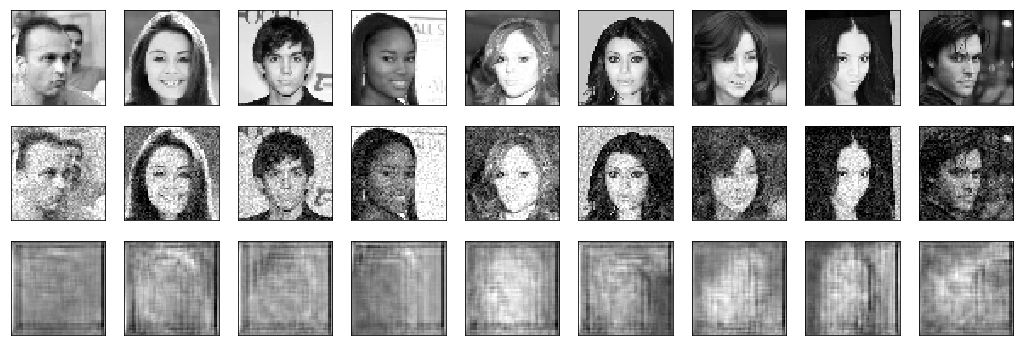

0.27491796131229024


In [11]:
decoded_imgs = dae.predict(x_true_test_noisy)
which=np.linspace(6,15,10)
n = 10
plt.figure(figsize=(20, 6))
for i in range(1,n):
    
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_true_test[[i+1]].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_true_test_noisy[i+1].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i+1].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
measure=np.mean(abs(decoded_imgs-x_true_test))
print(measure)

## MODEL 2 : Convolutional Autoencoder

In [12]:
# Training and test data
x_test_cae = images
x_test_cae = x_test_cae.astype('float32') / 255.
x_test_cae = np.reshape(x_test_cae, (len(x_test_cae), 56, 56, 1))

In [13]:
input_img = Input(shape=(56, 56, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x) 

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.load_weights('cae_weights.h5')

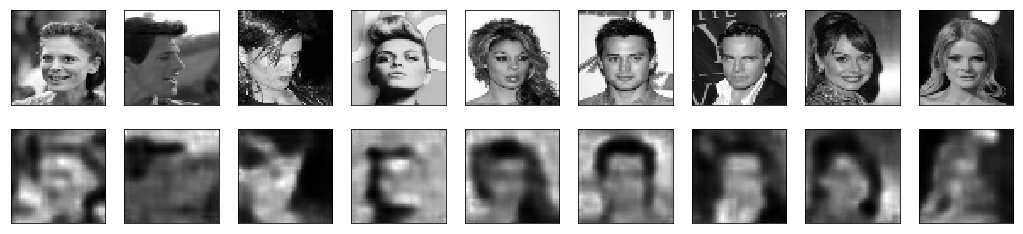

In [12]:
decoded_imgs =  autoencoder.predict(x_test_cae)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_cae[i].reshape(56,56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()